# Lending Club Dataset Analysis

### Problem Statement
Analyze the Lending Club dataset [https://www.lendingclub.com/info/download-data.action] and generate a set of key performance metrics for the product management team of a loan product. Come up with some recommendations on how to improve the product / predictability of defaults.

### Cleaning the Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

# read data
df = pd.read_csv('LoanStats07_11.csv', skiprows=1)

# df.info(verbose=True, null_counts=True)

/Users/hsu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove empty features (columns) and observations (rows).

In [2]:
# chop off empty columns
df.drop(df.columns[47:], axis=1, inplace=True)
# chop off empty rows
df.drop(df.index[42536:], axis=0, inplace=True)
df = df[np.isfinite(df['loan_amnt'])]

# df.info(verbose=True, null_counts=True)

Remove features that 1) have no predictive power [e.g. member_id, url], 2. are non-ordinal, qualitative, and have a feature space close to size n [e.g. title, desc, zip_code], or 3. leaked the correct prediction or ground truth into the test data [e.g. months_since_last delinq, collection_recovery_fee].

In [3]:
# remove irrelevant columns
df.drop(['id', 
         'member_id', 
         'sub_grade', 
         'emp_title', 
         'pymnt_plan', 
         'url', 
         'desc', 
         'title', 
         'mths_since_last_delinq', 
         'mths_since_last_record', 
         'zip_code', 
         'pub_rec', 
         'initial_list_status', 
         'out_prncp', 
         'out_prncp_inv', 
         'recoveries', 
         'last_pymnt_d', 
         'last_pymnt_amnt',
         'collection_recovery_fee'
        ], axis=1, inplace=True)

Convert rates from string types to numeric types.

In [4]:
# convert rates to floats
df['int_rate'] = pd.Series(df.int_rate).str.replace('%', '').astype(float)
df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

Identify and remove highly correlated / redundant features.

In [5]:
# identify highly correlated attributes
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt      loan_amnt          0.981746
funded_amnt_inv  loan_amnt          0.929598
                 funded_amnt        0.947525
installment      loan_amnt          0.930869
                 funded_amnt        0.956522
                 funded_amnt_inv    0.890148
total_acc        open_acc           0.693161
total_pymnt      loan_amnt          0.884529
                 funded_amnt        0.900787
                 funded_amnt_inv    0.874397
                 installment        0.853595
total_pymnt_inv  loan_amnt          0.845737
                 funded_amnt        0.861747
                 funded_amnt_inv    0.914909
                 installment        0.804328
                 total_pymnt        0.964122
total_rec_prncp  loan_amnt          0.848800
                 funded_amnt        0.866810
                 funded_amnt_inv    0.838624
                 installment        0.845690
                 total_pymnt        0.971391
                 total_pymnt_inv    0.933000
total_rec_

In [6]:
# remove redundant columns
df.drop(['funded_amnt', 
         'funded_amnt_inv', 
         'installment', 
         'total_acc', 
         'total_pymnt', 
         'total_pymnt_inv', 
         'total_rec_prncp', 
         'total_rec_int'
        ], axis=1, inplace=True)

# df.info(verbose=True, null_counts=True)

Impute NaN values.

In [7]:
# clean up NaN values
df['annual_inc'].fillna((df['annual_inc'].median()), inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['open_acc'].fillna((df['open_acc'].median()), inplace=True)
df['revol_util'].fillna((df['revol_util'].mean()), inplace=True)

# df.info(verbose=True, null_counts=True)

Convert emp_length and dates from string types to numeric types.

In [8]:
# convert emp_length to int
df.emp_length = pd.Series(df.emp_length).str.strip('+ years')
df.emp_length = pd.Series(df.emp_length).str.replace('< 1', '0')
df['emp_len_new'] = df.emp_length.convert_objects(convert_numeric=True)
df['emp_len_new'].fillna((df['emp_len_new'].mean()), inplace=True)
df['emp_len_new'] = df['emp_len_new'].astype(int)
df.drop(['emp_length'], axis=1, inplace=True)

# df.info(verbose=True, null_counts=True)

/Users/hsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [9]:
# convert earliest_cr_line to "# of years since"
from datetime import datetime
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)
df['earliest_cr_yr'] = 2016 - df['earliest_cr_line'].dt.year
df['earliest_cr_yr'].fillna((df['earliest_cr_yr'].median()), inplace=True)
df['earliest_cr_yr'] = df['earliest_cr_yr'].astype(int)
df.drop(['earliest_cr_line'], axis=1, inplace=True)

In [10]:
# convert issue_d to "# of years since"
df.issue_d = pd.to_datetime(df.issue_d)
df['yrs_since_issue'] = 2016 - df['issue_d'].dt.year
df['yrs_since_issue'].fillna((df['yrs_since_issue'].median()), inplace=True)
df['yrs_since_issue'] = df['yrs_since_issue'].astype(int)
df.drop(['issue_d'], axis=1, inplace=True)

If memory becomes an issue, convert to smaller data types.

In [11]:
# convert to smaller type
# df.loan_amnt = pd.Series(df.loan_amnt).astype(int)
# df.dti = pd.Series(df.dti).astype(float)
# df.delinq_2yrs = pd.Series(df.delinq_2yrs).astype(int)
# df.inq_last_6mths = pd.Series(df.inq_last_6mths).astype(int)
# df.open_acc = pd.Series(df.open_acc).astype(int)

# df.info(verbose=True, null_counts=True)

In [12]:
# check for nulls
df.isnull().sum()

loan_amnt              0
term                   0
int_rate               0
grade                  0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
addr_state             0
dti                    0
delinq_2yrs            0
inq_last_6mths         0
open_acc               0
revol_bal              0
revol_util             0
total_rec_late_fee     0
emp_len_new            0
earliest_cr_yr         0
yrs_since_issue        0
dtype: int64

Since our model is predicting whether or not a loan has been defaulted on, loans with a "Current" status should be removed from the dataset because their default status is not yet known.

In [13]:
# drop current loans
df = df[df['loan_status'] != 'Current']
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41202 entries, 0 to 42535
Data columns (total 20 columns):
loan_amnt              41202 non-null float64
term                   41202 non-null object
int_rate               41202 non-null float64
grade                  41202 non-null object
home_ownership         41202 non-null object
annual_inc             41202 non-null float64
verification_status    41202 non-null object
loan_status            41202 non-null object
purpose                41202 non-null object
addr_state             41202 non-null object
dti                    41202 non-null float64
delinq_2yrs            41202 non-null float64
inq_last_6mths         41202 non-null float64
open_acc               41202 non-null float64
revol_bal              41202 non-null float64
revol_util             41202 non-null float64
total_rec_late_fee     41202 non-null float64
emp_len_new            41202 non-null int64
earliest_cr_yr         41202 non-null int64
yrs_since_issue        41202

In [14]:
df.head()

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_rec_late_fee,emp_len_new,earliest_cr_yr,yrs_since_issue
0,5000.0,36 months,10.65,B,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65,0.0,1.0,3.0,13648.0,83.7,0.00,10,31,5
1,2500.0,60 months,15.27,C,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00,0.0,5.0,3.0,1687.0,9.4,0.00,0,17,5
2,2400.0,36 months,15.96,C,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72,0.0,2.0,2.0,2956.0,98.5,0.00,10,15,5
3,10000.0,36 months,13.49,C,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00,0.0,1.0,10.0,5598.0,21.0,16.97,10,20,5
5,5000.0,36 months,7.90,A,RENT,36000.0,Source Verified,Fully Paid,wedding,AZ,11.20,0.0,3.0,9.0,7963.0,28.3,0.00,3,12,5


Encode labels.

In [15]:
df = df[df['loan_status'] != 
        'Does not meet the credit policy. Status:Fully Paid']
df = df[df['loan_status'] != 
        'Does not meet the credit policy. Status:Charged Off']
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default'], dtype=object)

In [16]:
df['loan_status_clean'] = df['loan_status'].map({'Fully Paid': 1, 
                                                 'Charged Off': 0, 
                                                 'Late (31-120 days)': 0, 
                                                 'In Grace Period': 0, 
                                                 'Late (16-30 days)': 0, 
                                                 'Default': 0})
df['loan_status_clean'] =  df['loan_status_clean'].astype(int)
df.drop(['loan_status'], axis=1, inplace=True)

Ordinal encoding of features where applicable.

In [17]:
# ordinal mapping of term
term_mapping = {' 36 months': 1, ' 60 months': 2}
df['term'] = df['term'].map(term_mapping)

In [18]:
# ordinal mapping of grade
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df['grade'] = df['grade'].map(grade_mapping)

In [19]:
# ordinal mapping of verification_status
vs_mapping = {'Verified': 3, 
              'Source Verified': 2, 
              'Not Verified': 1}
df['verification_status'] = df['verification_status'].map(vs_mapping)

One-hot encoding of qualitative features.

In [20]:
# one-hot encoding of qualitative features
# just_dummies = pd.get_dummies(df[['home_ownership', 'purpose', 'addr_state']])
# df = pd.concat([df, just_dummies], axis=1)
df.drop(['home_ownership', 'purpose', 'addr_state'], axis=1, inplace=True)
# df.info(verbose=True, null_counts=True)

In [21]:
# move labels to first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,loan_status_clean,loan_amnt,term,int_rate,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_rec_late_fee,emp_len_new,earliest_cr_yr,yrs_since_issue
0,1,5000.0,1,10.65,6,24000.0,3,27.65,0.0,1.0,3.0,13648.0,83.7,0.00,10,31,5
1,0,2500.0,2,15.27,5,30000.0,2,1.00,0.0,5.0,3.0,1687.0,9.4,0.00,0,17,5
2,1,2400.0,1,15.96,5,12252.0,1,8.72,0.0,2.0,2.0,2956.0,98.5,0.00,10,15,5
3,1,10000.0,1,13.49,5,49200.0,2,20.00,0.0,1.0,10.0,5598.0,21.0,16.97,10,20,5
5,1,5000.0,1,7.90,7,36000.0,2,11.20,0.0,3.0,9.0,7963.0,28.3,0.00,3,12,5


Now that our dataset is cleaned up, let's try applying a few machine learning models and drawing insights from them.

# Analyzing the Data

### Assessing Feature Importance with Random Forests

In [22]:
# split data set into training and test sets
from sklearn.cross_validation import train_test_split
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[1:]

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=1000,
                                random_state=1,
                                n_jobs=-1)

forest.fit(X_train, y_train)
print('Training accuracy:', forest.score(X_train, y_train))
print('Test accuracy:', forest.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.859483356449


Using a random forest, we can measure feature importance as the averaged **"impurity decrease"** (that is, choose the feature that when split on, maximized the difference between the impurity of the parent node and the sum of the impurities of the child nodes) computed from all the decision trees in the forest.

 1) annual_inc                     0.106454
 2) revol_util                     0.106001
 3) revol_bal                      0.105287
 4) dti                            0.104738
 5) int_rate                       0.104256
 6) loan_amnt                      0.086385
 7) earliest_cr_yr                 0.074673
 8) open_acc                       0.065662
 9) emp_len_new                    0.052533
10) total_rec_late_fee             0.052333
11) inq_last_6mths                 0.031308
12) grade                          0.030681
13) term                           0.022990
14) verification_status            0.022434
15) yrs_since_issue                0.022155
16) delinq_2yrs                    0.012111


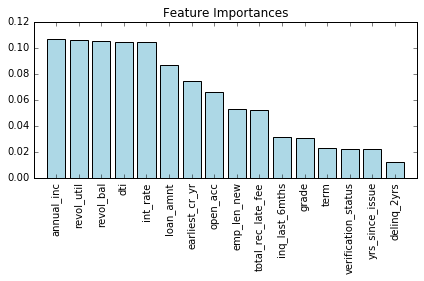

In [24]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

It looks like annual income, revolving utilization, revolving balance, DTI, and interest rates are the most important/predictive features in the model. Seems reasonable. Interestingly, none of these features seem to be highly correlated when examined pair-wise.

### Default Prediction Using Logistic Regression

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [26]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1', C=10000, random_state=1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.8565590519
Test accuracy: 0.849861303745


### Assessing Bias/Variance Trade-off with Learning Curves

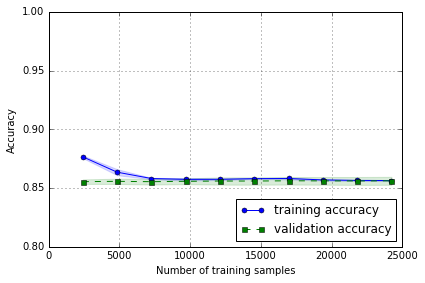

In [27]:
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l1', C=10000, random_state=1))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                   X=X_train,
                                                   y=y_train,
                                                   train_sizes=np.linspace(0.1, 1.0, 10),
                                                   cv=10,
                                                   n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

Judging by the learning curves, I would say the model suffers from high bias. The training and validation curves converge, but at a low level of accuracy. Adding more training examples wouldn't help, as the training and validation curves converge very early. If I had more time, I would do more feature engineering (e.g. adding more features, adding higher order features) to increase the flexibility of the model. Increasing C, the inverse regularization parameter, doesn't seem to do much.

In [28]:
# logistic regression model weights
lr.coef_

array([[  1.89055716e-02,  -2.96673936e-01,  -5.46738814e-01,
         -1.25158975e-01,   4.90422758e-01,   7.89695495e-03,
          6.00784375e-03,  -4.58965378e-04,  -1.52643124e-01,
          8.21346885e-03,  -5.18914996e-02,  -9.40581352e-02,
         -2.95614566e-01,  -2.43960464e-02,  -5.02672917e-02,
         -1.94921607e-02]])